In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14,8)

In [2]:
class MonteCarloPortfolio:

    def __init__(self, asset_names, mean_returns, std_returns, corr_matrix, n_simulations=700):

        self.asset_names = asset_names
        self.mean_returns = np.array(mean_returns)
        self.std_returns = np.array(std_returns)
        self.corr_matrix = np.array(corr_matrix)
        self.n_assets = len(mean_returns)
        self.n_simulations = n_simulations
        
        self.cov_matrix = self._compute_covariance_matrix()
        
        print(f"\nInitialized Monte Carlo Portfolio with {self.n_assets} assets")
        print(f"Simulations: {self.n_simulations}")

    def _compute_covariance_matrix(self):
        """Compute covariance matrix from standard deviations and correlation matrix."""
        std_diag = np.diag(self.std_returns)
        return std_diag @ self.corr_matrix @ std_diag

    def display_parameters(self):
        """Display input paramters in formatted table."""
        print("\n" + "="*80)
        print("Portfolio Paramters")
        print("="*80)

        df = pd.DataFrame({
        'Asset': self.asset_names,
        'Expected Return': self.mean_returns,
        'Volatility (Std Dev)': self.std_returns
        })
        print(df.to_string(index=False))

        print("\nCorrelation Matrix:")
        corr_df = pd.DataFrame(self.corr_matrix,
                                index=self.asset_names,
                                columns=self.asset_names)
        print(corr_df.round(3))

        print("\nCovariance Matrix:")
        cov_df = pd.DataFrame(self.cov_matrix,
                                index=self.asset_names,
                                columns=self.asset_names)
        print(cov_df.round(6))

    def generate_returns_scenarios(self):
        """
        Generate multivariate normal return scenarios.
        Returns:
        --------
        ndarray of shape (n_simulations, n_assets)
        """
        np.random.seed(1111)
        return np.random.multivariate_normal(
            self.mean_returns,
            self.cov_matrix,
            self.n_simulations
        )

    def generate_random_weights(self, allow_shorts=True):
        """
        Generate random portfolio weights.
        Parameters:
        -----------
        allow_shorts : bool
            If True, allows negative weights (short positions)
            If False, constrains to long-only positions

        Returns:
        --------
        ndarray of shape (n_simulations, n_assets)
        """
        np.random.seed(9999)
        weights_matrix = np.zeros((self.n_simulations, self.n_assets))

        if allow_shorts:
            for i in range(self.n_simulations):
                weights = np.random.uniform(-1, 1, self.n_assets -1)
                last_weight = 1 - np.sum(weights)
                weights_matrix[i] = np.append(weights, last_weight)
        else:
            for i in range(self.n_simulations):
                weights = np.random.uniform(0, 1, self.n_assets)
                weights_matrix[i] = weights / np.sum(weights)

        return weights_matrix

    def compute_portfolio_metrics(self, weights_matrix, returns_scenarios):
        """Compute portfolio return and risk for each weight combination.
        Parameters:
        -----------
        weights_matrix : ndarray
            Matrix of portfolio weights (n_simulations x n_assets)
        returns_scenarios : ndarray
            Matrix of return scenarios (n_simulations x n_assets)

        Returns:
        --------
        DataFrame with portfolio metrics
        """
        results = []

        for i, weights in enumerate(weights_matrix):
            portfolio_returns = returns_scenarios @ weights

            mean_return = np.mean(portfolio_returns)

            std_return = np.sqrt(weights @ self.cov_matrix @ weights)

            sharpe_ratio = mean_return / std_return if std_return > 0 else 0

            has_shorts = np.any(weights < 0)

            result = {f'w{j+1}': weights[j] for j in range(self.n_assets)}
            result.update({
                'mean_return': mean_return,
                'std_return': std_return,
                'sharpe_ratio': sharpe_ratio,
                'has_shorts': has_shorts
            })
            results.append(result)

        return pd.DataFrame(results)

    def run_simulation(self, allow_shorts=True):
        """
        Run complete Monte Carlo simulation.
        Parameters:
        -----------
        allow_shorts : bool
            Allow short positions or long-only

        Returns:
        --------
        DataFrame with portfolio results
        """
        print(f"\nRunning simulation: {'Shorts Allowed' if allow_shorts else 'Long Positions Only'}")

        returns_scenarios = self.generate_returns_scenarios()

        weights_matrix = self.generate_random_weights(allow_shorts)

        results_df = self.compute_portfolio_metrics(weights_matrix, returns_scenarios)

        results_df['position_type'] = results_df['has_shorts'].apply(
            lambda x: 'Has Short(s)' if x else 'No Shorts'
        )

        print(f" Generated {len(results_df)} random portfolios")
        print(f"\nSummary Statistics:")
        print(results_df[['mean_return', 'std_return', 'sharpe_ratio']].describe())

        return results_df

    def find_efficient_frontier_portfolios(self, resuts_df):
        """
        Identify portfolios on the efficient frontier.
        For each level of risk, find the portfolio with maximum return.
        """

        sorted_df = results_df.sort_values('std_return')

        efficient = []
        max_return = -np.inf

        for idx, row in sorted_df.iterrows():
            if row['mean_return'] > max_return:
                max_return = row['mean_return']
                efficient.append(row)

        return pd.DataFrame(efficient)

    def plot_results(self, results_long, results_short):
        """
        Create visualization comparing long-only vs. shorts-allowed strategies.
        """
        fig, axes = plt.subplots(1, 2, figsize=(16, 7))

        ax = axes[0]
        colors = results_long['position_type'].map({'Has Short(s)': 'red', 'No Shorts': 'darkblue'})
        ax.scatter(results_long['std_return'], results_long['mean_return'],
                    c=colors, alpha=0.6, s=20)
        ax.set_xlabel('Risk: Standard Deviation of Portfolio Returns', fontsize=12)
        ax.set_ylabel('Return: Mean of Portfolio Returns', fontsize=12)
        ax.set_title('Long Postions Only', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)

        ax = axes[1]
        colors = results_short['position_type'].map({'Has Short(s)': 'red', 'No Shorts': 'darkblue'})
        ax.scatter(results_short['std_return'], results_short['mean_return'],
                    c=colors, alpha=0.6, s=20)
        ax.set_xlabel('Risk: Standard Deviation of Portfolio Returns', fontsize=12)
        ax.set_ylabel('Return: Mean of Portfolio Returns', fontsize=12)
        ax.set_title('Shorts OK', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)

        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor='red', label='Has Short(s)'),
                            Patch(facecolor='darkblue', label='No Shorts')]
        ax.legend(handles=legend_elements, title='Positions', loc='best')

        plt.tight_layout()
        return fig

In [3]:
print("\n" + "="*80)
print("Scenario 1: Four Generic Assets")
print("="*80)

asset_names_1 = ['A', 'B', 'C', 'D']
mean_returns_1 = [0.02, 0.07, 0.15, 0.20]
std_returns_1 = [0.05, 0.12, 0.17, 0.25]
corr_matrix_1 = [
    [1.0, 0.3, 0.3, 0.3],
    [0.3, 1.0, 0.6, 0.6],
    [0.3, 0.6, 1.0, 0.6],
    [0.3, 0.6, 0.6, 1.0]
]

portfolio_1 = MonteCarloPortfolio(
    asset_names_1,
    mean_returns_1,
    std_returns_1,
    corr_matrix_1,
    n_simulations=700
)

portfolio_1.display_parameters()

results_1_long = portfolio_1.run_simulation(allow_shorts=False)
results_1_short = portfolio_1.run_simulation(allow_shorts=True)


Scenario 1: Four Generic Assets

Initialized Monte Carlo Portfolio with 4 assets
Simulations: 700

Portfolio Paramters
Asset  Expected Return  Volatility (Std Dev)
    A             0.02                  0.05
    B             0.07                  0.12
    C             0.15                  0.17
    D             0.20                  0.25

Correlation Matrix:
     A    B    C    D
A  1.0  0.3  0.3  0.3
B  0.3  1.0  0.6  0.6
C  0.3  0.6  1.0  0.6
D  0.3  0.6  0.6  1.0

Covariance Matrix:
         A        B        C        D
A  0.00250  0.00180  0.00255  0.00375
B  0.00180  0.01440  0.01224  0.01800
C  0.00255  0.01224  0.02890  0.02550
D  0.00375  0.01800  0.02550  0.06250

Running simulation: Long Positions Only
 Generated 700 random portfolios

Summary Statistics:
       mean_return  std_return  sharpe_ratio
count   700.000000  700.000000    700.000000
mean      0.107630    0.124758      0.860377
std       0.021687    0.022879      0.051403
min       0.043050    0.057539      0.6


--------------------------------------------------------------------------------
Optimal Portfolios - Scenario 1
--------------------------------------------------------------------------------

Best Portfolio (Long Only):
 Weights: A=0.215, B=0.005, C=0.613, D=0.168
 Expected Return: 0.1302
 Volatility: 0.1379
 Sharpe Ratio: 0.9440

Best Portfolio (Shorts Allowed):
 Weights: A=0.404, B=-0.103, C=0.508, D=0.1911
 Expected Return: 0.1155
 Volatility: 0.1214
 Sharpe Ratio: 0.9518


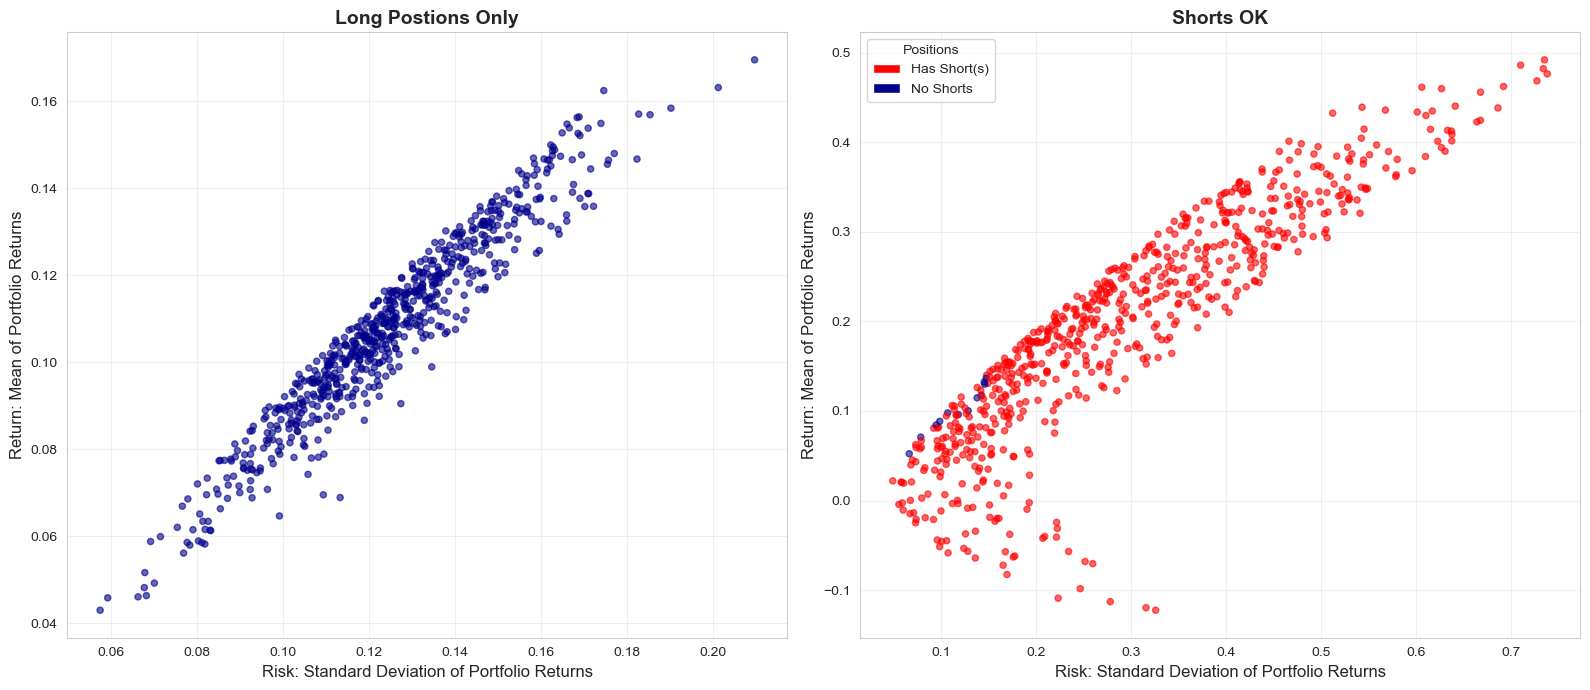

n Saved: scenario1_efficient_frontier.png


In [4]:
print("\n" + "-"*80)
print("Optimal Portfolios - Scenario 1")
print("-"*80)

best_long_1 = results_1_long.loc[results_1_long['sharpe_ratio'].idxmax()]
print("\nBest Portfolio (Long Only):")
print(f" Weights: A={best_long_1['w1']:.3f}, B={best_long_1['w2']:.3f}, "
      f"C={best_long_1['w3']:.3f}, D={best_long_1['w4']:.3f}")
print(f" Expected Return: {best_long_1['mean_return']:.4f}")
print(f" Volatility: {best_long_1['std_return']:.4f}")
print(f" Sharpe Ratio: {best_long_1['sharpe_ratio']:.4f}")

best_short_1 = results_1_short.loc[results_1_short['sharpe_ratio'].idxmax()]
print("\nBest Portfolio (Shorts Allowed):")
print(f" Weights: A={best_short_1['w1']:.3f}, B={best_short_1['w2']:.3f}, "
      f"C={best_short_1['w3']:.3f}, D={best_short_1['w4']:.4f}")
print(f" Expected Return: {best_short_1['mean_return']:.4f}")
print(f" Volatility: {best_short_1['std_return']:.4f}")
print(f" Sharpe Ratio: {best_short_1['sharpe_ratio']:.4f}")

fig1 = portfolio_1.plot_results(results_1_long, results_1_short)
plt.savefig('scenario1_efficient_frontier.png', dpi=300, bbox_inches='tight')
plt.show()
print("n Saved: scenario1_efficient_frontier.png")

In [5]:
print("\n" + "="*80)
print("Scenario 2: ATTF Four-Sleeve Portfolio")
print("="*80)

print("\nLoading ATTF dta from Checkpoint A...")
try:
    attf_data = pd.read_csv('attf_polygon_data_extended.csv', index_col=0, parse_dates=True)
    print(f" Loaded data: {len(attf_data)} rows, {len(attf_data.columns)} securities")
    print(f" Date range: {attf_data.index[0]} to {attf_data.index[-1]}")
except FileNotFoundError:
    print("Error: attf_polygon_data_extended.csv not found!")
    print("Please ensure the file is in the same directory as this notebook.")
    raise

sleeves = {
    'AI_Infrastructure': ['NVDA', 'AMD', 'INTC', 'MU', 'NBIS', 'GOOGL'],
    'Robotics_Space': ['RKLB', 'JOBY', 'ACHR', 'TSLA'],
    'Crypto': ['COIN', 'HOOD', 'IBIT', 'IREN', 'CLSK'],
    'Quantum': ['IONQ', 'RGTI', 'QBTS', 'SMR', 'SERV']
}

print("\nSleeve Compositions:")
for sleeve_name, tickers in sleeves.items():
    print(f" {sleeve_name}: {', '.join(tickers)}")

returns = attf_data.pct_change().dropna()

sleeve_returns = pd.DataFrame()

for sleeve_name, tickers in sleeves.items():
    available_tickers = [t for t in tickers if t in returns.columns]

    if len(available_tickers) == 0:
        print(f"Warning: No data available for {sleeve_name}")
        continue

    sleeve_returns[sleeve_name] = returns[available_tickers].mean(axis=1)

    missing = set(tickers) - set(available_tickers)
    if missing:
        print(f" Note: {sleeve_name} missing {missing}")

print(f"\n Calculated sleeve returns for {len(sleeve_returns.columns)} sleeves")


Scenario 2: ATTF Four-Sleeve Portfolio

Loading ATTF dta from Checkpoint A...
 Loaded data: 2511 rows, 20 securities
 Date range: 2015-10-16 04:00:00 to 2025-10-10 04:00:00

Sleeve Compositions:
 AI_Infrastructure: NVDA, AMD, INTC, MU, NBIS, GOOGL
 Robotics_Space: RKLB, JOBY, ACHR, TSLA
 Crypto: COIN, HOOD, IBIT, IREN, CLSK
 Quantum: IONQ, RGTI, QBTS, SMR, SERV

 Calculated sleeve returns for 4 sleeves


In [6]:
mean_returns_2 = sleeve_returns.mean() * 252
std_returns_2 = sleeve_returns.std() * np.sqrt(252)
corr_matrix_2 = sleeve_returns.corr().values

asset_names_2 = sleeve_returns.columns.tolist()

print("\nAnnualized Sleeve Statistics:")
stats_df = pd.DataFrame({
    'Expected Return': mean_returns_2,
    'Volatility': std_returns_2
})
print(stats_df)

portfolio_2 = MonteCarloPortfolio(
    asset_names_2,
    mean_returns_2.values,
    std_returns_2.values,
    corr_matrix_2,
    n_simulations=700
)

portfolio_2.display_parameters()

results_2_long = portfolio_2.run_simulation(allow_shorts=False)
results_2_short = portfolio_2.run_simulation(allow_shorts=True)
    
    


Annualized Sleeve Statistics:
                   Expected Return  Volatility
AI_Infrastructure         0.374276    0.306547
Robotics_Space            0.285709    0.393572
Crypto                    0.291515    0.438094
Quantum                   0.410222    0.512323

Initialized Monte Carlo Portfolio with 4 assets
Simulations: 700

Portfolio Paramters
            Asset  Expected Return  Volatility (Std Dev)
AI_Infrastructure         0.374276              0.306547
   Robotics_Space         0.285709              0.393572
           Crypto         0.291515              0.438094
          Quantum         0.410222              0.512323

Correlation Matrix:
                   AI_Infrastructure  Robotics_Space  Crypto  Quantum
AI_Infrastructure              1.000           0.460   0.389    0.301
Robotics_Space                 0.460           1.000   0.526    0.515
Crypto                         0.389           0.526   1.000    0.397
Quantum                        0.301           0.515   0.397 

In [7]:
print("\n" + "-"*80)
print("Optimal Portfolios - Scenario 2 (ATTF)")
print("-"*80)

best_long_2 = results_2_long.loc[results_2_long['sharpe_ratio'].idxmax()]
print("\nBest Portfolio (Long Only):")
for i, name in enumerate(asset_names_2):
    print(f" {name}: {best_long_2[f'w{i+1}']:.3f}")
print(f" Expected Return: {best_long_2['mean_return']:.4f}")
print(f" Volatility: {best_long_2['std_return']:.4f}")
print(f" Sharpe Ratio: {best_long_2['sharpe_ratio']:.4f}")

best_short_2 = results_2_short.loc[results_2_short['sharpe_ratio'].idxmax()]
print("\nBest Portfolio (Shorts Allowed):")
for i, name in enumerate(asset_names_2):
    print(f" {name}: {best_short_2[f'w{i+1}']:.3f}")
print(f" Expected Return: {best_short_2['mean_return']:.4f}")
print(f" Volatility: {best_short_2['std_return']:.4f}")
print(f" Sharpe Ratio: {best_short_2['sharpe_ratio']:.4f}")


--------------------------------------------------------------------------------
Optimal Portfolios - Scenario 2 (ATTF)
--------------------------------------------------------------------------------

Best Portfolio (Long Only):
 AI_Infrastructure: 0.669
 Robotics_Space: 0.027
 Crypto: 0.165
 Quantum: 0.140
 Expected Return: 0.3525
 Volatility: 0.2836
 Sharpe Ratio: 1.2429

Best Portfolio (Shorts Allowed):
 AI_Infrastructure: 0.777
 Robotics_Space: -0.104
 Crypto: 0.123
 Quantum: 0.204
 Expected Return: 0.3711
 Volatility: 0.2932
 Sharpe Ratio: 1.2660


In [8]:
checkpoint_a_weights = [0.40, 0.30, 0.20, 0.10]
checkpoint_a_return = np.dot(checkpoint_a_weights, mean_returns_2.values)
checkpoint_a_vol = np.sqrt(np.dot(checkpoint_a_weights,
                                  np.dot(portfolio_2.cov_matrix, checkpoint_a_weights)))
checkpoint_a_sharpe = checkpoint_a_return / checkpoint_a_vol

print("\n" + "-"*80)
print("Comparison: Optimized vs. Checkpoint A Allocation")
print("-"*80)
print("\nCheckpoint A Fixed Allocation (40/30/20/10):")
for i, name in enumerate(asset_names_2):
    print(f" {name}: {checkpoint_a_weights[i]:.3f}")
print(f" Expected Return: {checkpoint_a_return:.4f}")
print(f" Volatility: {checkpoint_a_vol:.4f}")
print(f" Sharpe Ratio: {checkpoint_a_sharpe:.4f}")

print("\nImprovement with Optimization (Long Only):")
print(f" Return improvement: {(best_long_2['mean_return'] - checkpoint_a_return):.4f} "
      f"({(best_long_2['mean_return'] / checkpoint_a_return - 1)*100:.2f}%)")
print(f" Risk reduction: {(best_long_2['std_return'] - checkpoint_a_vol):.4f} "
      f"({(best_long_2['std_return'] / checkpoint_a_vol - 1)*100:.2f}%")
print(f" Sharpe improvement: {(best_long_2['sharpe_ratio'] - checkpoint_a_sharpe):.4f} "
      f"({(best_long_2['sharpe_ratio'] / checkpoint_a_sharpe - 1)*100:.2f}%)")
    


--------------------------------------------------------------------------------
Comparison: Optimized vs. Checkpoint A Allocation
--------------------------------------------------------------------------------

Checkpoint A Fixed Allocation (40/30/20/10):
 AI_Infrastructure: 0.400
 Robotics_Space: 0.300
 Crypto: 0.200
 Quantum: 0.100
 Expected Return: 0.3347
 Volatility: 0.2922
 Sharpe Ratio: 1.1455

Improvement with Optimization (Long Only):
 Return improvement: 0.0178 (5.31%)
 Risk reduction: -0.0086 (-2.94%
 Sharpe improvement: 0.0974 (8.51%)


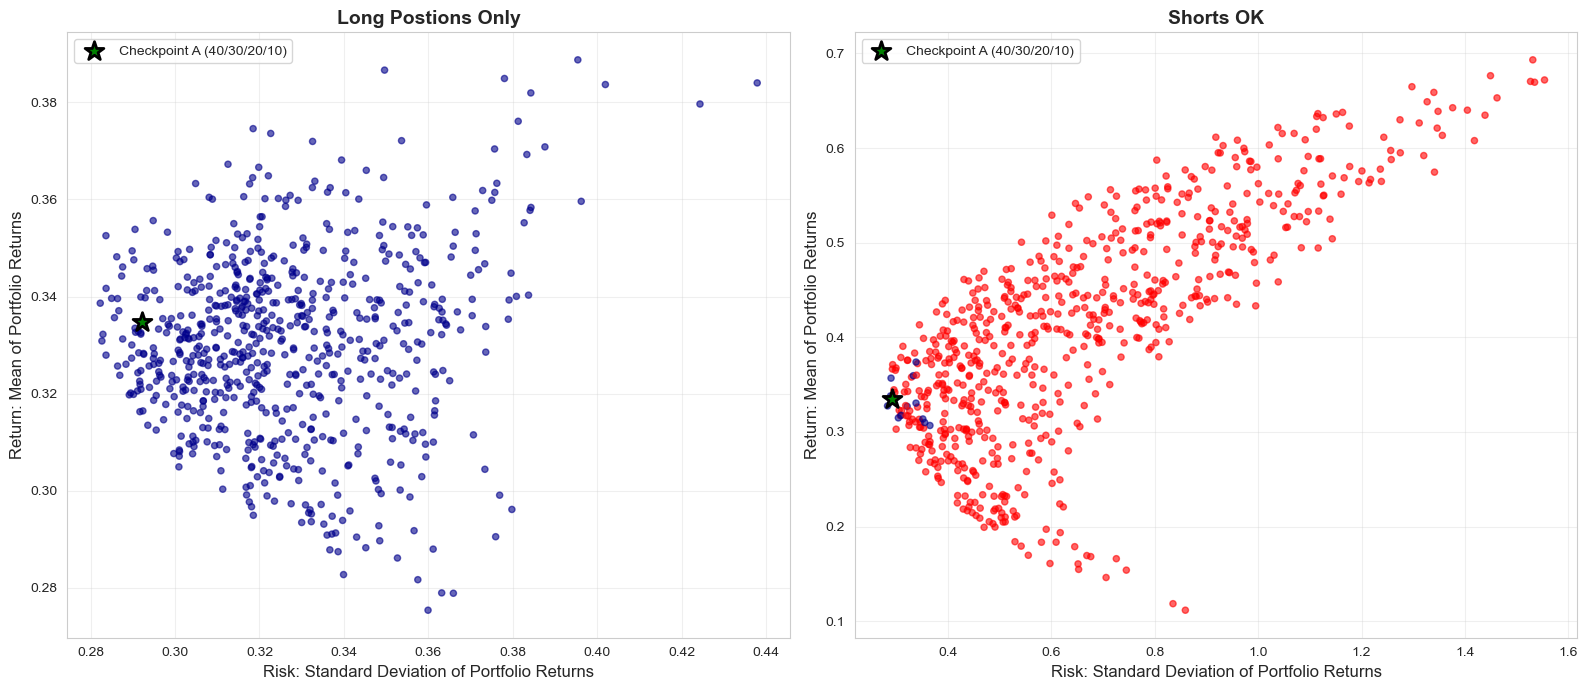


 Saved: scenario2_attf_efficient_frontier.png


In [9]:
fig2 = portfolio_2.plot_results(results_2_long, results_2_short)

for ax in fig2.axes:
    ax.scatter(checkpoint_a_vol, checkpoint_a_return,
               c='green', s=200, marker='*', edgecolors='black', linewidth=2,
               label='Checkpoint A (40/30/20/10)', zorder=5)
    ax.legend()

plt.savefig('sceneario2_attf_efficient_frontier.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n Saved: scenario2_attf_efficient_frontier.png")

In [10]:
print("\m" + "="*80)
print("Saving Results")
print("="*80)

results_1_long.to_csv('scenario1_results_long_only.csv', index=False)
results_1_short.to_csv('scenario1_results_short_allowed.csv', index=False)
print(" Saved Scenario 1 results")

results_2_long.to_csv('scenario2_attf_results_long_only.csv', index=False)
results_2_short.to_csv('scenario2_attf_results_shorts_allowed.csv', index=False)
print(" Saved Scenario 2 results")

optimal_portfolios = pd.DataFrame({
    'Scenario': ['1: Generic Assets (Long Only)',
                 '1: Generic Assets (Shorts OK)',
                 '2: ATTF (Long Only)',
                 '2: ATTF (Shorts OK)',
                 '2: ATTF Checkpoint A'],
    'Expected_Return': [best_long_1['mean_return'],
                        best_short_1['mean_return'],
                        best_long_2['mean_return'],
                        best_short_2['mean_return'],
                        checkpoint_a_return],
    'Volatility': [best_long_1['std_return'],
                   best_short_1['std_return'],
                   best_long_2['std_return'],
                   best_short_2['std_return'],
                   checkpoint_a_vol],
    'Sharpe_Ratio': [best_long_1['std_return'],
                     best_short_1['std_return'],
                     best_long_2['std_return'],
                     best_short_2['std_return'],
                     checkpoint_a_sharpe]
})

optimal_portfolios.to_csv('optimal_portfolios_summary.csv', index=False)
print(" Saved optimal portfolios summary")

print("\nKey Findings:")
print(f"1. Scenario 1 best Sharpe (long-only): {best_long_1['sharpe_ratio']:.4f}")
print(f"2. Scenario 1 best Sharpe (shorts OK): {best_short_1['sharpe_ratio']:.4f}")
print(f"3. Scenario 2 (ATTF) best Sharpe (long-only): {best_long_2['sharpe_ratio']:.4f}")
print(f"4. Scenario 2 (ATTF) best Sharpe (shorts OK): {best_short_2['sharpe_ratio']:.4f}")
print(f"5. Checkpoint A Sharpe: {checkpoint_a_sharpe:.4f}")
print(f"\nOptimization improved ATTF Sharpe ratio by: "
      f"{(best_long_2['sharpe_ratio'] / checkpoint_a_sharpe - 1)*100:.2f}%")


\m================================================================================
Saving Results
 Saved Scenario 1 results
 Saved Scenario 2 results
 Saved optimal portfolios summary

Key Findings:
1. Scenario 1 best Sharpe (long-only): 0.9440
2. Scenario 1 best Sharpe (shorts OK): 0.9518
3. Scenario 2 (ATTF) best Sharpe (long-only): 1.2429
4. Scenario 2 (ATTF) best Sharpe (shorts OK): 1.2660
5. Checkpoint A Sharpe: 1.1455

Optimization improved ATTF Sharpe ratio by: 8.51%
